Before outlier removal: 59615 matches
Connected pairs: 1034 / 1035
After outlier removal:
Connected pairs: 244 / 1035
Triangulating: 398 points.
Initial image pair: [18, 20]
Adding image 19 (from 18)
PnP avg error: 0.12px, inlier fraction: 100.00%
Triangulating: 233 points.
Avg reprojection error on image 18: 0.135 px
Avg reprojection error on image 19: 0.135 px
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.7453e+01                                    1.75e+04    
       1              4         6.9208e+01      8.25e+00       1.81e-01       1.90e+04    
       2              6         6.2157e+01      7.05e+00       8.83e-02       4.96e+03    
       3              7         5.7561e+01      4.60e+00       1.68e-01       2.21e+04    
`ftol` termination condition is satisfied.
Function evaluations 7, initial cost 7.7453e+01, final cost 5.7561e+01, first-order optimality 2.21e+04.
Image 19 reprojection err: 0.07p

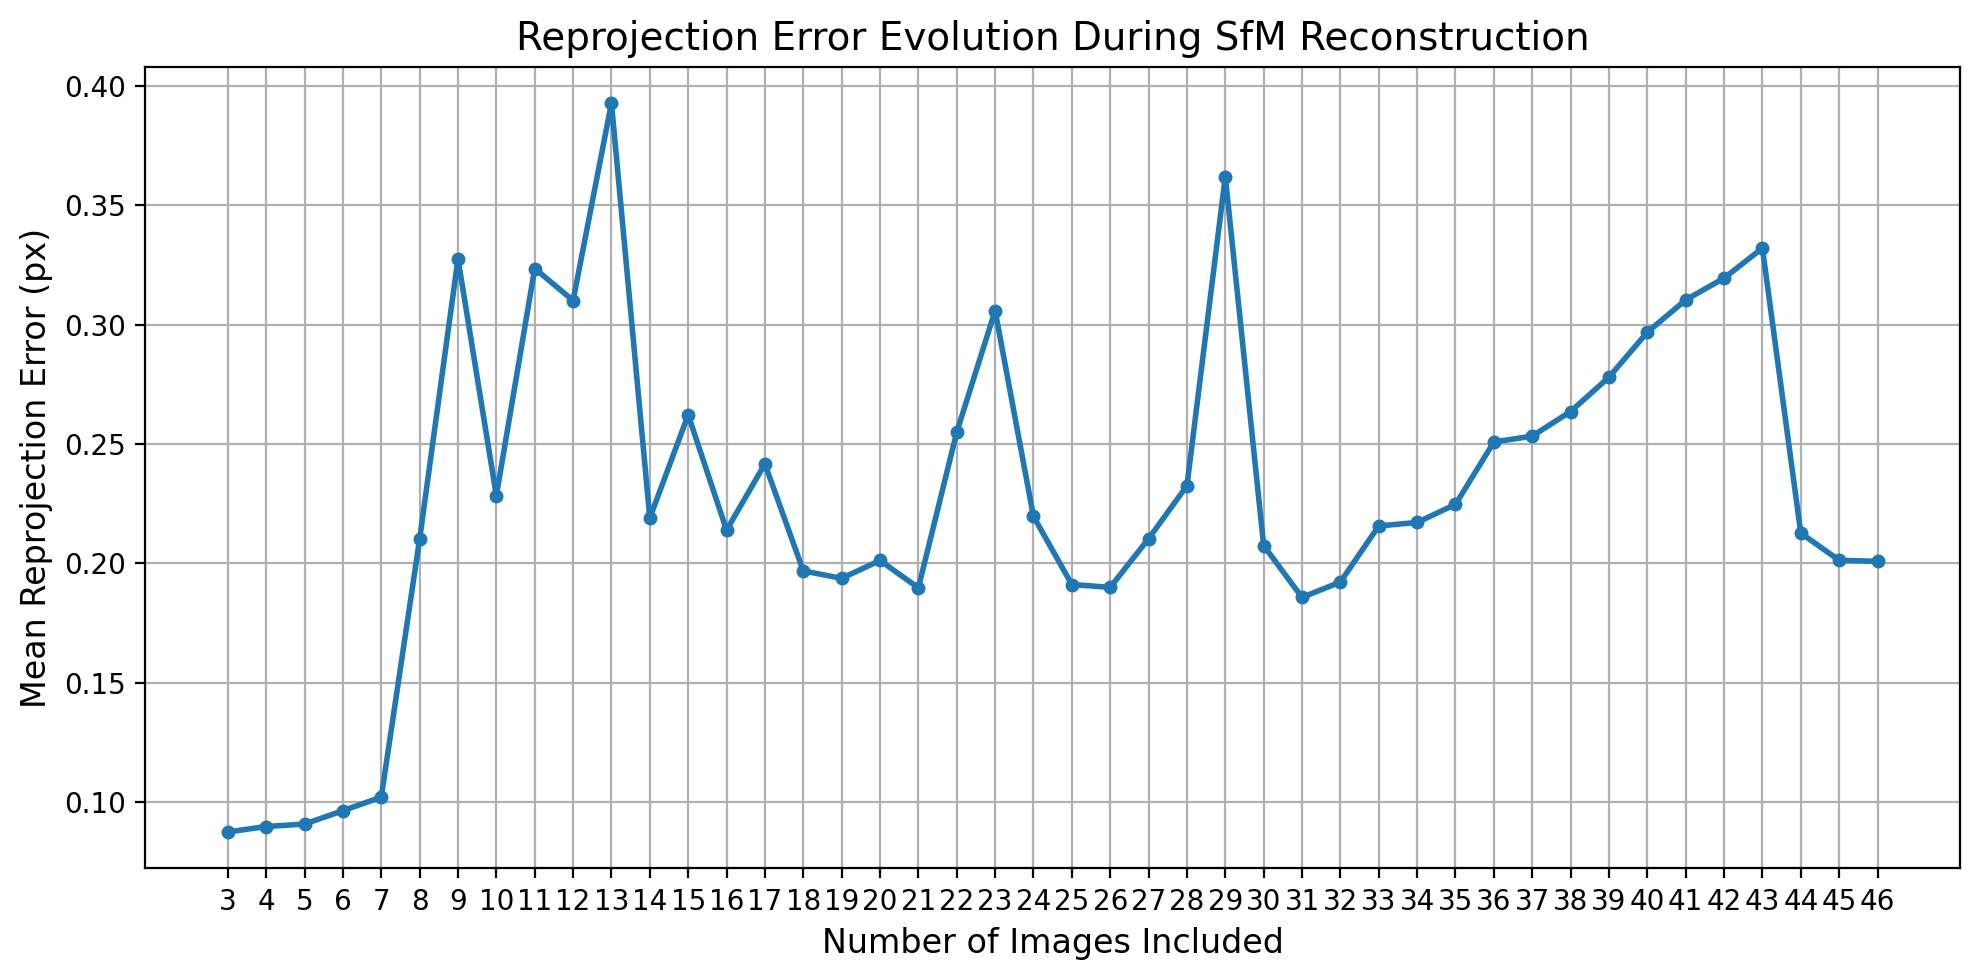

Saved point cloud to output_point_cloud.ply
[Open3D WARNING] GLFW Error: WGL: Failed to make context current: Descripteur non valide 


In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

# Ensure compatibility for numpy.int
if not hasattr(np, 'int'):
    np.int = int

# Display settings for inline plotting
%matplotlib inline
mpl.rcParams['figure.dpi'] = 200

# --- Feature matching imports ---
from feature_matching.image_load import load_images
from feature_matching.feature_extraction import extract_sift_features
from feature_matching.feature_matching import match_sift_descriptors
from feature_matching.outlier_remover import filter_correspondences
from feature_matching.utilies import (
    build_adjacency_matrix,
    count_total_matches,
    display_connected_pairs
)

# --- Reconstruction imports ---
from reconstructioning.initialization import select_initial_image_pair
from reconstructioning.reconstruct import initialize_reconstruction
from reconstructioning.selection import select_next_image_pair
from reconstructioning.geometry import extract_matched_keypoints
from reconstructioning.pnp import (
    fetch_pnp_correspondences,
    estimate_pose_pnp,
    evaluate_pnp_reprojection
)
from reconstructioning.triangulation import triangulate_and_reproject
from reconstructioning.reprojection_error import get_reprojection_errors
from bundle_adjustement.solver import bundle_adjust

# --- Visualization imports ---
import open3d as o3d

# --- Configuration ---
# N_IMAGES = 48
# IMGSET = 'dingoring'

N_IMAGES = 46
IMGSET = 'templering'
DATA_DIR = Path('./datasets')

BA_CHECKPOINTS = [3, 4, 5, 6] + [int(6 * (1.34**i)) for i in range(25)]

# --- Load images and intrinsics ---
images, K = load_images(IMGSET, N_IMAGES, DATA_DIR)

# --- Feature extraction and matching ---
keypoints, descriptors = extract_sift_features(images)
matcher = cv2.BFMatcher(cv2.NORM_L1)
raw_matches = match_sift_descriptors(descriptors, matcher)

print(f"Before outlier removal: {count_total_matches(raw_matches)} matches")
display_connected_pairs(raw_matches)

# Remove outliers, rebuild adjacency
filter_correspondences(raw_matches, keypoints)
print("After outlier removal:")
display_connected_pairs(raw_matches)
adjacency_matrix, connected_pairs = build_adjacency_matrix(N_IMAGES, raw_matches)

# --- Initialize reconstruction ---
initial_pair = select_initial_image_pair(
    adjacency_matrix, raw_matches, keypoints, K, top_percent=0.2
)
R0, t0, R1, t1, points3d_with_views = initialize_reconstruction(
    keypoints, raw_matches, K, *initial_pair
)

# --> INSERT HERE: Initialize reprojection error lists
image_numbers = []
mean_reprojection_errors = []

# Store poses
R_mats = {initial_pair[0]: R0, initial_pair[1]: R1}
t_vecs = {initial_pair[0]: t0, initial_pair[1]: t1}

# Track which images are in/out of reconstruction
resected_imgs = list(initial_pair)
unresected_imgs = [i for i in range(N_IMAGES) if i not in resected_imgs]

print(f"Initial image pair: {resected_imgs}")


# --- Incremental reconstruction loop ---
while unresected_imgs:    
    # 1) Select next image to add
    placed_idx, new_idx, prepend = select_next_image_pair(
        N_IMAGES, initial_pair, resected_imgs, unresected_imgs
    )

    # 2) Collect PnP correspondences
    points3d_with_views, pts3d_pnp, pts2d_pnp, tri_status = fetch_pnp_correspondences(
        placed_idx, new_idx, points3d_with_views, raw_matches, keypoints
    )

    # 3) Skip if too few matches
    if len(pts3d_pnp) < 12:
        print(f"Only {len(pts3d_pnp)} PnP correspondences; skipping {new_idx}")
        continue

    # 4) Estimate new pose via PnP
    R_res, t_res = R_mats[placed_idx], t_vecs[placed_idx]
    print(f"Adding image {new_idx} (from {placed_idx})")
    R_new, t_new = estimate_pose_pnp(pts3d_pnp, pts2d_pnp, K)
    R_mats[new_idx], t_vecs[new_idx] = R_new, t_new

    # 5) Update lists
    if prepend:
        resected_imgs.insert(0, new_idx)
    else:
        resected_imgs.append(new_idx)
    unresected_imgs.remove(new_idx)

    # 6) Evaluate reprojection of PnP
    pnp_errs, _, avg_pnp_err, pnp_inliers = evaluate_pnp_reprojection(
        pts3d_pnp, pts2d_pnp, R_new, t_new, K
    )
    print(f"PnP avg error: {avg_pnp_err:.2f}px, inlier fraction: {pnp_inliers:.2%}")

    # 7) Triangulate new points
    i1, i2 = (placed_idx, new_idx) if placed_idx < new_idx else (new_idx, placed_idx)
    k1, k2, idxs1, idxs2 = extract_matched_keypoints(
        i1, i2, keypoints, raw_matches, mask=tri_status
    )
    if tri_status.any():
        args = (R_res, t_res, R_new, t_new, K,
                points3d_with_views, placed_idx, new_idx,
                k1, k2, idxs1, idxs2)
        if placed_idx < new_idx:
            points3d_with_views, tri_errs, err_l, err_r = triangulate_and_reproject(*args, reproject=True)
        else:
            # swap left/right for proper order
            points3d_with_views, tri_errs, err_l, err_r = triangulate_and_reproject(
                R_new, t_new, R_res, t_res, K,
                points3d_with_views, new_idx, placed_idx,
                k1, k2, idxs1, idxs2, reproject=True
            )

    # 8) Conditional bundle adjustment
    if (0.8 < pnp_inliers < 0.95) or (5 < err_l < 10) or (5 < err_r < 10):
        points3d_with_views, R_mats, t_vecs = bundle_adjust(
            points3d_with_views, R_mats, t_vecs,
            resected_imgs, keypoints, K, ftol=1e0
        )
    if len(resected_imgs) in BA_CHECKPOINTS or not unresected_imgs or pnp_inliers <= 0.8 or err_l >= 10 or err_r >= 10:
        points3d_with_views, R_mats, t_vecs = bundle_adjust(
            points3d_with_views, R_mats, t_vecs,
            resected_imgs, keypoints, K, ftol=1e-1
        )

    # 9) Global reprojection stats
    total_err = 0
    for im in resected_imgs:
        _, _, avg_err_img, _ = get_reprojection_errors(
            im, points3d_with_views, R_mats[im], t_vecs[im], K, keypoints
        )
        print(f"Image {im} reprojection err: {avg_err_img:.2f}px")
        total_err += avg_err_img
    mean_err = total_err / len(resected_imgs)
    print(f"Mean reprojection error: {mean_err:.2f}px\n")

    image_numbers.append(len(resected_imgs))
    mean_reprojection_errors.append(mean_err)

# Plot reprojection errors at essential steps
plt.figure(figsize=(10, 5))
plt.plot(image_numbers, mean_reprojection_errors, '-o', linewidth=2, markersize=4)
plt.grid(True)
plt.title('Reprojection Error Evolution During SfM Reconstruction', fontsize=14)
plt.xlabel('Number of Images Included', fontsize=12)
plt.ylabel('Mean Reprojection Error (px)', fontsize=12)
plt.xticks(image_numbers) 
plt.tight_layout()
plt.show()


# --- Point cloud visualization with Open3D ---
# Extracting points under threshold
coords = np.vstack([pt.coords.flatten() for pt in points3d_with_views])
mask = np.abs(coords).sum(axis=1) < 100
filtered = coords[mask]
if filtered.size == 0:
    raise RuntimeError("No valid points for visualization.")

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(filtered)

# Estimate voxel size and create voxel grid
bbox = pcd.get_axis_aligned_bounding_box()
diag = np.linalg.norm(bbox.get_max_bound() - bbox.get_min_bound())
voxel_size = diag / 50
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size)

# Save and visualize
o3d.io.write_point_cloud("output_point_cloud.ply", pcd)
print("Saved point cloud to output_point_cloud.ply")
o3d.visualization.draw_geometries([pcd, voxel_grid], window_name="Reconstruction")

# Standalone PLY viewer
ply = o3d.io.read_point_cloud("output_point_cloud.ply")
if ply.is_empty():
    print("PLY load failed or empty.")
else:
    o3d.visualization.draw_geometries([ply], window_name="PLY Viewer")
    
